In [13]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore
from typing import List
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage
import uuid

In [2]:
load_dotenv()

True

In [3]:
# Create a LTM store
store = InMemoryStore()

In [4]:
# Define a system prompt
SYSTEM_PROMPT_TEMPLATE = """You are a helpful assistant with memory capabilities.
If user-specific memory is available, use it to personalize 
your responses based on what you know about the user.

Your goal is to provide relevant, friendly, and tailored 
assistance that reflects the user’s preferences, context, and past interactions.

If the user’s name or relevant personal context is available, always personalize your responses by:
    – Always Address the user by name (e.g., "Sure, Nitish...") when appropriate
    – Referencing known projects, tools, or preferences (e.g., "your MCP server python based project")
    – Adjusting the tone to feel friendly, natural, and directly aimed at the user

Avoid generic phrasing when personalization is possible.

Use personalization especially in:
    – Greetings and transitions
    – Help or guidance tailored to tools and frameworks the user uses
    – Follow-up messages that continue from past context

Always ensure that personalization is based only on known user details and not assumed.

In the end suggest 3 relevant further questions based on the current response and user profile

The user’s memory (which may be empty) is provided as: {user_details_content}
"""

In [5]:
# Create a memory extraction LLM
memory_llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

In [8]:
class MemoryItem(BaseModel):
    content: str = Field(description="Atomic user memory in a short sentence")
    is_new: bool = Field(description="TRUE if the memory is new to the user, FALSE if duplicated")

In [9]:
class MemoryDecision(BaseModel):
    create_memory: bool = Field(description="TRUE if a new memory should be created, FALSE if not")
    memories: List[MemoryItem] = Field(description="List of user memories to be added to the store")

In [10]:
memory_extractor = memory_llm.with_structured_output(MemoryDecision)

In [11]:
MEMORY_PROMPT = """You are responsible for updating and maintaining accurate user memory.

CURRENT USER DETAILS (existing memories):
{user_details_content}

TASK:
- Review the user's latest message.
- Extract user-specific info worth storing long-term (identity, stable preferences, ongoing projects/goals).
- For each extracted item, set is_new=true ONLY if it adds NEW information compared to CURRENT USER DETAILS.
- If it is basically the same meaning as something already present, set is_new=false.
- Keep each memory as a short atomic sentence.
- No speculation; only facts stated by the user.
- If there is nothing memory-worthy, return should_write=false and an empty list.
"""

In [14]:
def remember_node(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
   user_id = config['configurable']['user_id']
   
   namespace = ('user', user_id, 'responses')
   
   # Retrieve existing user memories
   items = store.search(namespace)
   existing_memories = "\n".join(item.value['data'] for item in items) if items else ""
   
   # Get latest user message
   last_message = state['messages'][-1].content
   
   decision: MemoryDecision = memory_extractor.invoke(
       [
           SystemMessage(content=MEMORY_PROMPT.format(user_details_content=existing_memories)),
           {"role": "user", "content": f"User Message:\n{last_message}"}
       ]
   )
   
   if decision.create_memory:
       for memory in decision.memories:
           if memory.is_new:
               store.put(namespace, str(uuid.uuid4()), {"data": memory.content})
   return state

In [15]:
chat_llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

In [16]:
def chat_node(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config['configurable']['user_id']
    
    namespace = ('user', user_id, 'responses')
    
    # Retrieve existing user memories
    items = store.search(namespace)
    existing_memories = "\n".join(item.value['data'] for item in items) if items else ""
    
    system_message = SystemMessage(
        content=SYSTEM_PROMPT_TEMPLATE.format(
            user_details_content=existing_memories or "empty"
        )
    )
    
    response = chat_llm.invoke([system_message] + state['messages'])
    return {"messages": [response]}

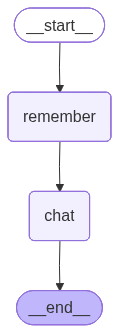

In [17]:
# Invoke the graph
graph = StateGraph(MessagesState)

# Add nodes to the graph
graph.add_node('remember', remember_node)
graph.add_node('chat', chat_node)

# Add edges to the graph
graph.add_edge(START, 'remember')
graph.add_edge('remember', 'chat')
graph.add_edge('chat', END)

# Compile the graph
workflow = graph.compile(store=store)
workflow

In [18]:
# Invoke the graph
config = {"configurable": {"user_id": "u1"}}

result = workflow.invoke({"messages": [{"role": "user", "content": "Hi, my name is Sayam Kumar."}]}, config=config)

print("Assistant Response:", result["messages"][-1].content)

Assistant Response: Hi Sayam! It's great to meet you. How can I assist you today?


In [19]:
for item in store.search(('user', 'u1', 'responses')):
    print(item.value['data'])

User's name is Sayam Kumar.


In [20]:
result = workflow.invoke({"messages": [{"role": "user", "content": "I love listening to music."}]}, config=config)
print("Assistant Response:", result["messages"][-1].content)

Assistant Response: That's great to hear, Sayam! Music can be such a wonderful way to relax and express yourself. Do you have a favorite genre or artist that you enjoy listening to?


In [21]:
for item in store.search(('user', 'u1', 'responses')):
    print(item.value['data'])

User's name is Sayam Kumar.
Sayam Kumar loves listening to music.


In [22]:
result = workflow.invoke({"messages": [{"role": "user", "content": "My favorite artist is Ed Sheeran."}]}, config=config)
print("Assistant Response:", result["messages"][-1].content)

Assistant Response: That's awesome, Sayam! Ed Sheeran has such a great range of music. Do you have a favorite song or album of his?


In [23]:
for item in store.search(('user', 'u1', 'responses')):
    print(item.value['data'])

User's name is Sayam Kumar.
Sayam Kumar loves listening to music.
Sayam Kumar's favorite artist is Ed Sheeran.


In [24]:
result = workflow.invoke({"messages": [{"role": "user", "content": "Explain agentic AI in simple terms"}]}, config=config)
print("Assistant Response:", result["messages"][-1].content)

Assistant Response: Sure, Sayam! Agentic AI refers to artificial intelligence systems that can act independently and make decisions on their own, rather than just following pre-programmed instructions. Think of it like a virtual assistant that not only responds to your commands but can also analyze situations, learn from experiences, and take actions based on its understanding of the environment.

For example, an agentic AI could manage your schedule by not only adding events but also suggesting optimal times for meetings based on your preferences and past behavior. It’s about giving AI a level of autonomy to operate and make choices that can benefit users in a more dynamic way.

If you have any specific applications of agentic AI in mind or want to know more about how it might relate to your interests, feel free to ask!

Here are a few questions you might consider:
1. Are you interested in how agentic AI could be used in music recommendations?
2. Do you want to know about any specific

In [25]:
for item in store.search(('user', 'u1', 'responses')):
    print(item.value['data'])

User's name is Sayam Kumar.
Sayam Kumar loves listening to music.
Sayam Kumar's favorite artist is Ed Sheeran.
